In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [7]:
print(sklearn.__version__)

0.24.1


In [9]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [11]:
data = pd.read_csv('stoch_corr_arctan_1000.csv', header=None)

In [13]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1002:1003]

In [15]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [17]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 999)


In [19]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             65024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 71,377
Trainable params: 71,377
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(
    optimizer="adam",
    loss='mse',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.20, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/25
2500/2500 [==============================] - 38s 13ms/step - loss: 0.0397 - val_loss: 0.0216
Epoch 2/25
2500/2500 [==============================] - 27s 11ms/step - loss: 0.0201 - val_loss: 0.0176
Epoch 3/25
2500/2500 [==============================] - 31s 12ms/step - loss: 0.0162 - val_loss: 0.0194
Epoch 4/25
2500/2500 [==============================] - 31s 12ms/step - loss: 0.0140 - val_loss: 0.0165
Epoch 5/25
 797/2500 [========>.....................] - ETA: 17s - loss: 0.0129

KeyboardInterrupt: 

In [16]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.15:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    # print(test_output, params_reshape[i])

100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


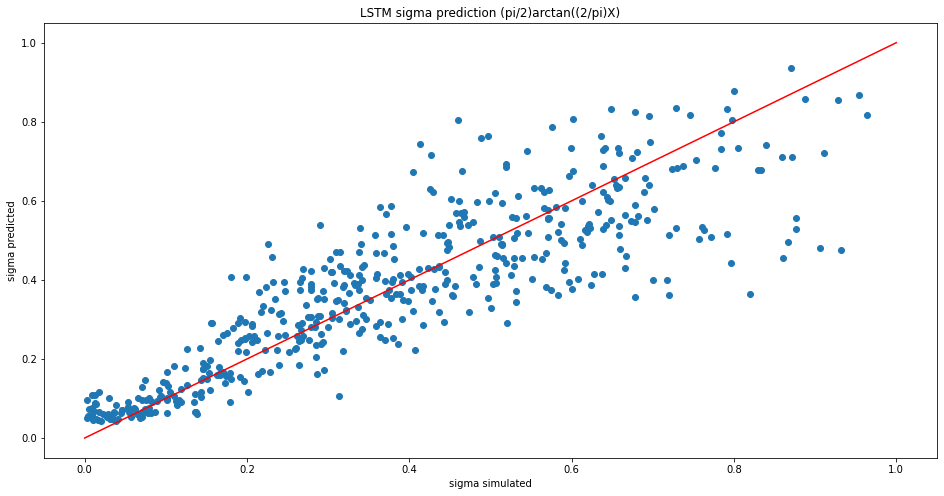

In [18]:
plt.figure(figsize=(16,8))
plt.plot([0,1], [0,1], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('sigma simulated')
plt.ylabel('sigma predicted')
plt.title('LSTM sigma prediction (pi/2)arctan((2/pi)X)')
plt.show()

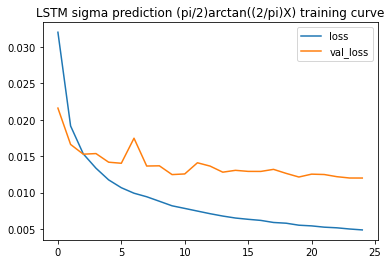

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM sigma prediction (pi/2)arctan((2/pi)X) training curve')
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
data = np.array([predicted, simulated]).reshape(2, 500)
pd.DataFrame(data).transpose().to_excel('arctan_lstm_sigma_v1_preds.xlsx')